In [1]:
import numpy as np
from matplotlib import pyplot as plt

# Initial Conditions

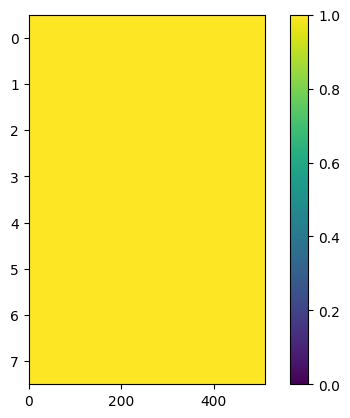

In [29]:
aspt = 100
data = np.loadtxt("./output/rho-0.txt")
plt.imshow(data,vmin=0,vmax=1,aspect=aspt)
plt.colorbar()

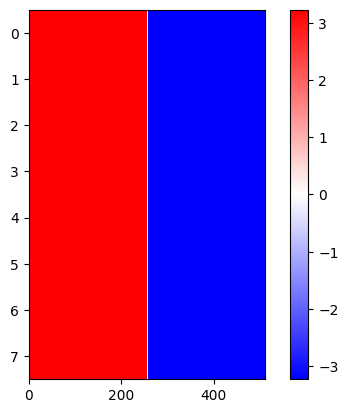

In [30]:
data = np.loadtxt("./output/u-0.txt")
plt.imshow(data,cmap='bwr',aspect=aspt)
plt.colorbar()

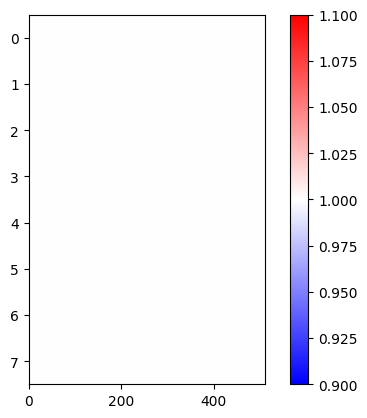

In [31]:
data = np.loadtxt("./output/By-0.txt")
plt.imshow(data,cmap='bwr',aspect=aspt)
plt.colorbar()

# Final Output

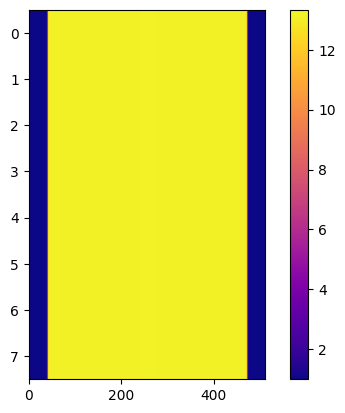

In [32]:
data = np.loadtxt("./output/p.txt")
plt.imshow(data,aspect=aspt,cmap='plasma')
plt.colorbar()

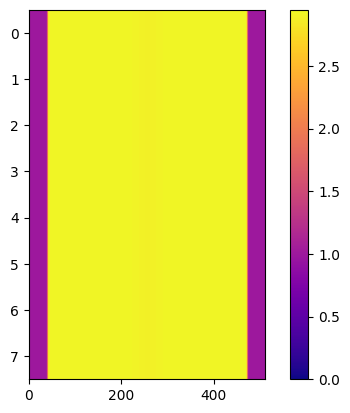

In [33]:
data = np.loadtxt("./output/rho.txt")
plt.imshow(data,vmin=0,aspect=aspt,cmap='plasma')
plt.colorbar()

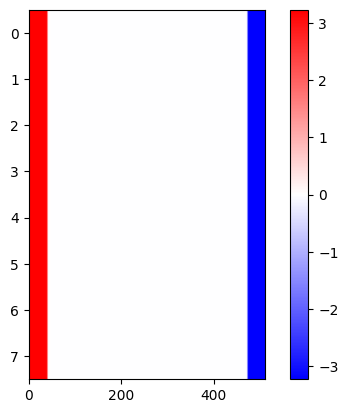

In [34]:
data = np.loadtxt("./output/u.txt")
plt.imshow(data,cmap='bwr',aspect=aspt)
plt.colorbar()

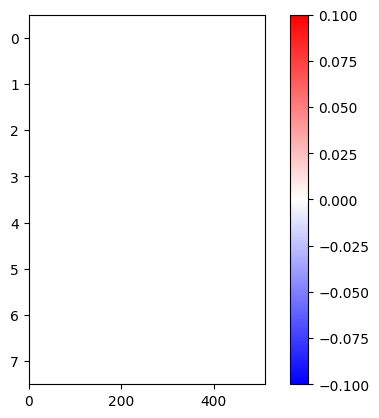

In [35]:
data = np.loadtxt("./output/v.txt")
plt.imshow(data,cmap='bwr',aspect=aspt)
plt.colorbar()

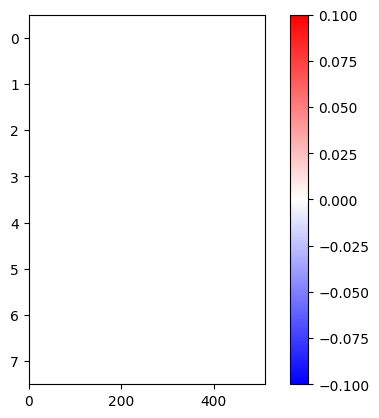

In [36]:
data = np.loadtxt("./output/Bx.txt")
plt.imshow(data,cmap='bwr',aspect=aspt)
plt.colorbar()

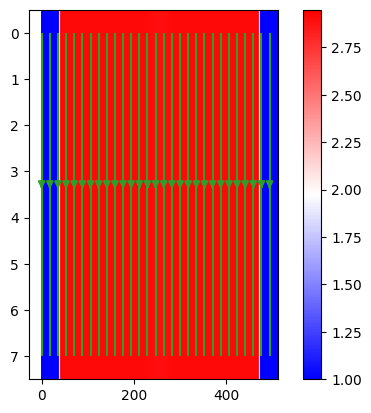

In [38]:
By = np.loadtxt("./output/By.txt")
Bx = np.loadtxt("./output/Bx.txt")

fig, axs = plt.subplots(1,1)
plt.imshow(By,cmap='bwr',aspect=aspt)
plt.colorbar()

m,n = By.shape
x, y = np.arange(0,n,1), np.arange(0,m,1)

axs.streamplot(x,y,Bx,By, density=1, color='tab:green')

# Output at given time

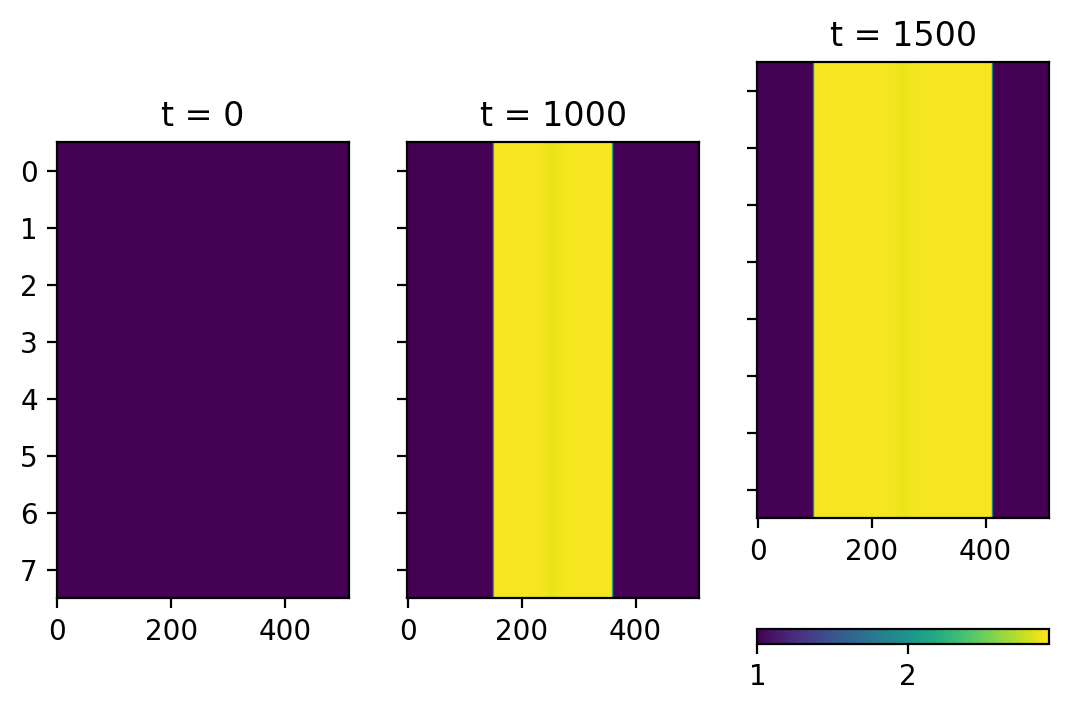

In [54]:
t = [0,1000,1500]
field = 'By'

fig, axs = plt.subplots(1,len(t),sharey=True,dpi=200)
for ii in range(len(t)):
    data = np.loadtxt('./output/' + field + '-' + str(t[ii]) + '.txt')
    im = axs[ii].imshow(data,aspect=aspt)
    axs[ii].set_title('t = ' + str(t[ii]))
    
plt.colorbar(im,orientation="horizontal")

# Compression vs Time

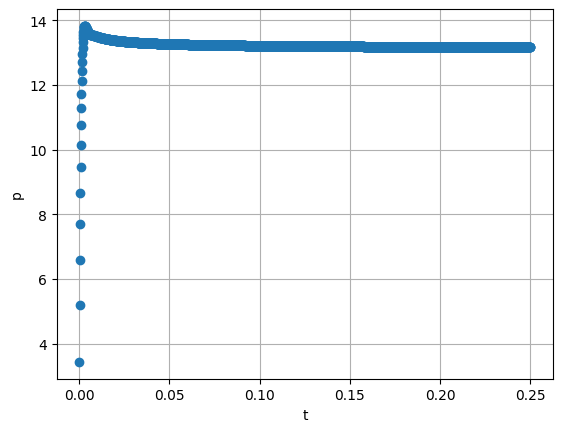

In [40]:
data = np.loadtxt("./output/p_vs_t.txt",delimiter=',')

plt.plot(data[:,0],data[:,1],'o',label='simulation')
plt.xlabel('t')
plt.ylabel('p')
plt.grid()




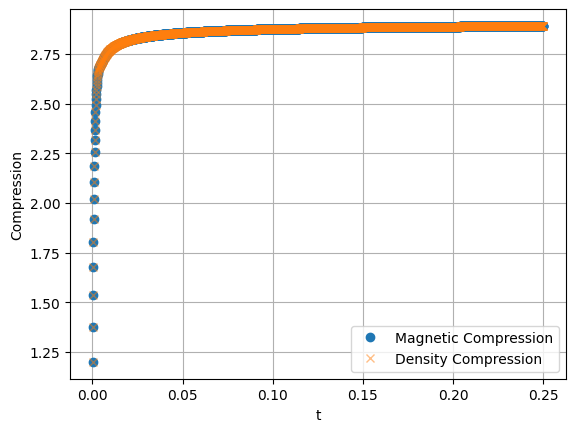

In [47]:
data = np.loadtxt("./output/By_vs_t.txt",delimiter=',')
plt.plot(data[:,0],data[:,1],'o',label='Magnetic Compression')

data = np.loadtxt("./output/rho_vs_t.txt",delimiter=',')
plt.plot(data[:,0],data[:,1],'x',label='Density Compression',alpha=0.5)

plt.xlabel('t')
plt.ylabel('Compression')
plt.legend()
plt.grid()



# Get Shock Velocity

Text(0.5, 1.0, 'u$_s$ = -1.6860766603663284')

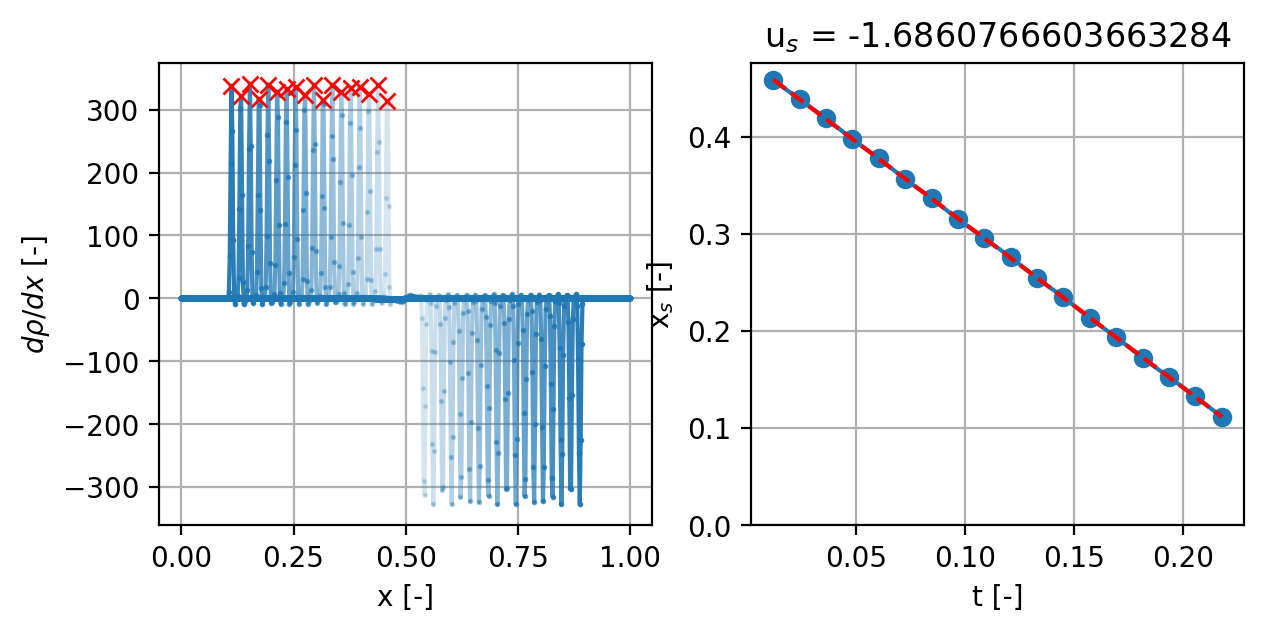

In [49]:
# Get shock front veloicty

step_nums = np.arange(200,2000,100)
fig, axs = plt.subplots(1,2,figsize=(7,3),dpi=200)


t, shock_pos = [], []

for ii,num in enumerate(step_nums):
    rho = np.loadtxt('./output/' + 'rho' + '-' + str(step_nums[ii]) + '.txt')
    t.append(100*1.21e-4*(ii+1))
    
    if ii == 0:
        m,n = rho.shape
        x, y = np.linspace(0,1,n), np.linspace(0,1,m)
        xx, yy = np.meshgrid(x,y)

    X = np.mean(xx,0)
    rho = np.mean(rho,0)
    drhodx = np.gradient(rho,X)

    idx = np.argmax(drhodx)
    shock_pos.append(X[idx])
    
    axs[0].plot(X,drhodx,'o-',markersize=1,alpha=0.1+0.9/2000*num,color='tab:blue')
    axs[0].plot(shock_pos[ii],drhodx[idx],'rx')

axs[0].set_xlabel('x [-]')
axs[0].grid()
axs[0].set_ylabel('$d\\rho/dx$ [-]')

axs[1].plot(t,shock_pos,'o-')
axs[1].set_xlabel('t [-]')
axs[1].set_ylabel('x$_s$ [-]')
axs[1].set_ylim(ymin=0)
axs[1].grid()

from scipy.optimize import curve_fit

def fn(t,v,c):
    return v * t + c # linear function

popt, pcov = curve_fit(fn,t,shock_pos)

u_shock = popt[0]

axs[1].plot(t,fn(np.array(t),popt[0],popt[1]),'r--')

axs[1].set_title('u$_s$ = ' + str(u_shock))

## Check with analytical solution

In [61]:
def FastShock_get_r(Ms,gamma,beta):
    # Density, Magnetic field compression ratio r [-]
    # Ms = Sonic Mach no. 
    # gamma = adibatic index
    # beta = Plasma beta
    a = 2 * (2 - gamma)
    b = 2 * gamma * (beta + 1) + beta * gamma * (gamma -1) * Ms**2
    c = -beta * gamma * (gamma+1)* Ms**2; 
    out1 = 1/(2*a) * (-b + np.sqrt(b**2 - 4 * a*c));
    out2 = 1/(2*a) * (-b - np.sqrt(b**2 - 4 * a*c));
    out = np.max([out1,out2])
    return out

def FastShock_get_R(Ms,gamma,beta): # dimensionless
    # Pressure compression ratio r [-]
    # Ms = Sonic Mach no. 
    # gamma = adibatic index
    # beta = Plasma beta
    r = FastShock_get_r(Ms,gamma,beta)
    R = 1 + (1-r**2)/beta + gamma * Ms**2 * (r -1) / r
    return R


Cs = np.sqrt(5/3 * 1 / 1)
beta = 1.0  / (1.0**2/1.0/2)
Ms = (2.5 * Cs - u_shock) / Cs # Mach no. in shock ref frame
gamma = 5/3 # Specific heat ratio for air
density_ratio, pressure_ratio = FastShock_get_r(Ms,gamma,beta), FastShock_get_R(Ms,gamma,beta)

print('Theoretical Values:')
print('M = %1.3f'%Ms)
print(f"Density ratio (ρ2/ρ1): {density_ratio:.4f}")
print(f"Pressure ratio (P2/P1): {pressure_ratio:.4f}")




Theoretical Values:
M = 3.806
Density ratio (ρ2/ρ1): 2.9174
Pressure ratio (P2/P1): 13.1119


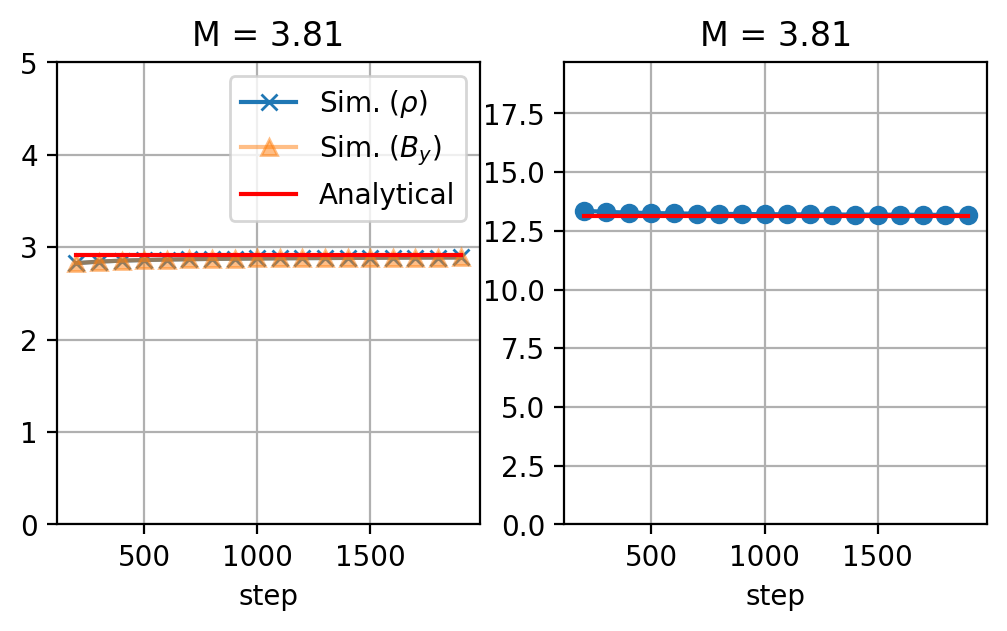

In [68]:
sim_den_rat = []
sim_B_rat = []
sim_p_rat = []

fig, axs = plt.subplots(1,2,sharex=True,figsize=(6,3),dpi=200)
for ii,num in enumerate(step_nums):
    rho = np.loadtxt('./output/' + 'rho' + '-' + str(step_nums[ii]) + '.txt')
    p = np.loadtxt('./output/' + 'p' + '-' + str(step_nums[ii]) + '.txt')
    By = np.loadtxt('./output/' + 'By' + '-' + str(step_nums[ii]) + '.txt')
    rho, p, By = np.mean(rho,0),  np.mean(p,0), np.mean(By,0)
    
    sim_den_rat.append(rho[rho.shape[0]//2] / rho[0])
    sim_p_rat.append(p[p.shape[0]//2] / p[0])
    sim_B_rat.append(By[By.shape[0]//2] / By[0])

axs[0].plot(step_nums,sim_den_rat,'-x',label='Sim. ($\\rho$)')
axs[0].plot(step_nums,sim_B_rat,'-^',label='Sim. ($B_y$)',alpha=0.5)
axs[1].plot(step_nums,sim_p_rat,'-o')

axs[0].set_ylim([0,5])
axs[1].set_ylim([0,pressure_ratio*1.5])

for ii in range(axs.shape[0]):
    axs[ii].grid()
    axs[ii].set_xlabel('step')
    axs[ii].set_title('M = ' + str(np.round(Ms,2)))
    
# Plot analytical value
axs[0].plot([np.min(step_nums),np.max(step_nums)],[density_ratio]*2,'-r',label='Analytical')
axs[1].plot([np.min(step_nums),np.max(step_nums)],[pressure_ratio]*2,'-r')

axs[0].legend()